## Training Set

In [117]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns

In [12]:
#import data 
from olist.data import Olist
olist=Olist()
data=olist.get_data()
matching_table=olist.get_matching_table()

### Distance between seller and customer 

In [125]:
# Since one zipcode can map to multiple [lat, lng], we take the first one
geo = data['olist_geolocation_dataset']
geo = geo.groupby('geolocation_zip_code_prefix', as_index=False).first()

In [127]:
#filter sellers and customers 
sellers = data['olist_sellers_dataset']
customers = data['olist_customers_dataset']

In [137]:
#merge geo_location for sellers
sellers_mask_columns = ['seller_id', 'seller_zip_code_prefix', 'seller_city', 
                        'seller_state', 'geolocation_lat', 'geolocation_lng']
sellers_geo = sellers.merge(geo,
                            how='left',
                            left_on='seller_zip_code_prefix',
                            right_on='geolocation_zip_code_prefix')[sellers_mask_columns]

In [138]:
#merge geo_location for customers
customers_mask_columns = ['customer_id', 'customer_zip_code_prefix', 'customer_city', 
                          'customer_state', 'geolocation_lat', 'geolocation_lng']
customers_geo = customers.merge(geo,
                            how='left',
                            left_on='customer_zip_code_prefix',
                            right_on='geolocation_zip_code_prefix')[customers_mask_columns]

In [145]:
#use the matching table and merge customers 
matching_geo = matching_table.merge(sellers_geo, 
                                    on='seller_id').merge(customers_geo, 
                                                          on='customer_id',
                                                          suffixes=('_seller', '_customer'))

In [141]:
#check that shape is correct
matching_geo.shape

(112650, 15)

In [160]:
#any na? 
matching_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 15 columns):
customer_id                 112650 non-null object
customer_unique_id          112650 non-null object
order_id                    112650 non-null object
product_id                  112650 non-null object
seller_id                   112650 non-null object
seller_zip_code_prefix      112650 non-null int64
seller_city                 112650 non-null object
seller_state                112650 non-null object
geolocation_lat_seller      112397 non-null float64
geolocation_lng_seller      112397 non-null float64
customer_zip_code_prefix    112650 non-null int64
customer_city               112650 non-null object
customer_state              112650 non-null object
geolocation_lat_customer    112348 non-null float64
geolocation_lng_customer    112348 non-null float64
dtypes: float64(4), int64(2), object(9)
memory usage: 13.8+ MB


We find that some rows for geo_seller and geo_customer are nulls. Let's remove them with dropna()

In [163]:
#remove na()
matching_geo = matching_geo.dropna()

In [113]:
# Compute distance between seller and customer (https://en.wikipedia.org/wiki/Haversine_formula)
from math import radians, sin, cos, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

In [ ]:
matching_geo['distance_seller_customer'] = matching_geo.apply(lambda x: haversine(x['geolocation_lng_seller'], x['geolocation_lat_seller'],
                                                                                  x['geolocation_lng_customer'], x['geolocation_lat_customer']), axis=1)

In [171]:
#Check that distance is roughly accurate in sampling 3 cases
matching_geo.sample(3)[['seller_city', 
                        'customer_city', 
                        'distance_seller_customer']]

,seller_city,customer_city,distance_seller_customer
72049,sao paulo,indaiatuba,77.409063
12658,ibitinga,guarapuava,487.551740
64171,cotia,franca,343.625155


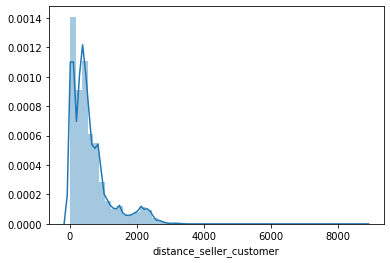

In [176]:
#A quick distribution plot for the road!
sns.distplot(matching_geo['distance_seller_customer'])

In [177]:
# Compute median distance
matching_geo['distance_seller_customer'].describe()

count    112096.000000
mean        597.187869
std         591.697498
min           0.000000
25%         183.303848
50%         431.753988
75%         792.109213
max        8736.947618
Name: distance_seller_customer, dtype: float64

In [180]:
#Since an order can have multiple sellers, return the average of the distance per order
matching_geo.groupby('order_id', 
                     as_index=False).agg({'distance_seller_customer': 'mean'})

,order_id,distance_seller_customer
0,00010242fe8c5a6d1ba2dd792cb16214,301.005664
1,00018f77f2f0320c557190d7a144bdd3,589.274140
2,000229ec398224ef6ca0657da4fc703e,312.495046
3,00024acbcdf0a6daa1e931b038114c75,301.951753
4,00042b26cf59d7ce69dfabb4e55b4fd9,646.221788
...,...,...
98172,fffc94f6ce00a00581880bf54a75a037,2755.314485
98173,fffcd46ef2263f404302a634eb57f7eb,354.848852
98174,fffce4705a9662cd70adb13d4a31832d,338.827218
98175,fffe18544ffabc95dfada21779c9644f,72.870476
